# Data exploration of a patient ECG

This notebook serves as a first contact with ECG data. For the purpose, the python package wfdb (https://wfdb.readthedocs.io/en/latest/) provides a set of tools which allow a very efficient way to read the files in the appropriate format as well as to annotate, plot and extract insights from them. Other packages will be used too, such as numpy, pandas and matplotlib, for numerical calculations, data processing and plotting options, respectively.

In [1]:
import wfdb
from wfdb import processing
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm


## Data lecture

For the moment, there is an example file from the patient dataset that will be loaded. This file is located inside the repository and corresponds to the patient 229. The folder includes 6 files: 2 different signals with the files .hea, .dat and .xyz. The library wfdb is optimized in such a way that it loads automatically all the information by giving the folder location as an input. For this work, I will load the signal corresponding to s0453_re sampling the first 10 seconds of the ECGs:

In [2]:
path = "ptb-diagnostic-ecg-database-1.0.0"
patient = "patient002"
ecg = "s0015lre"
record = wfdb.rdrecord(path + "/"+ patient+'/'+ecg, sampfrom=0)  # The units in samp are miliseconds, we sample 20 seconds


It is possible to get a glimpse of the signals by plotting them by using the functions of the library wfdb:

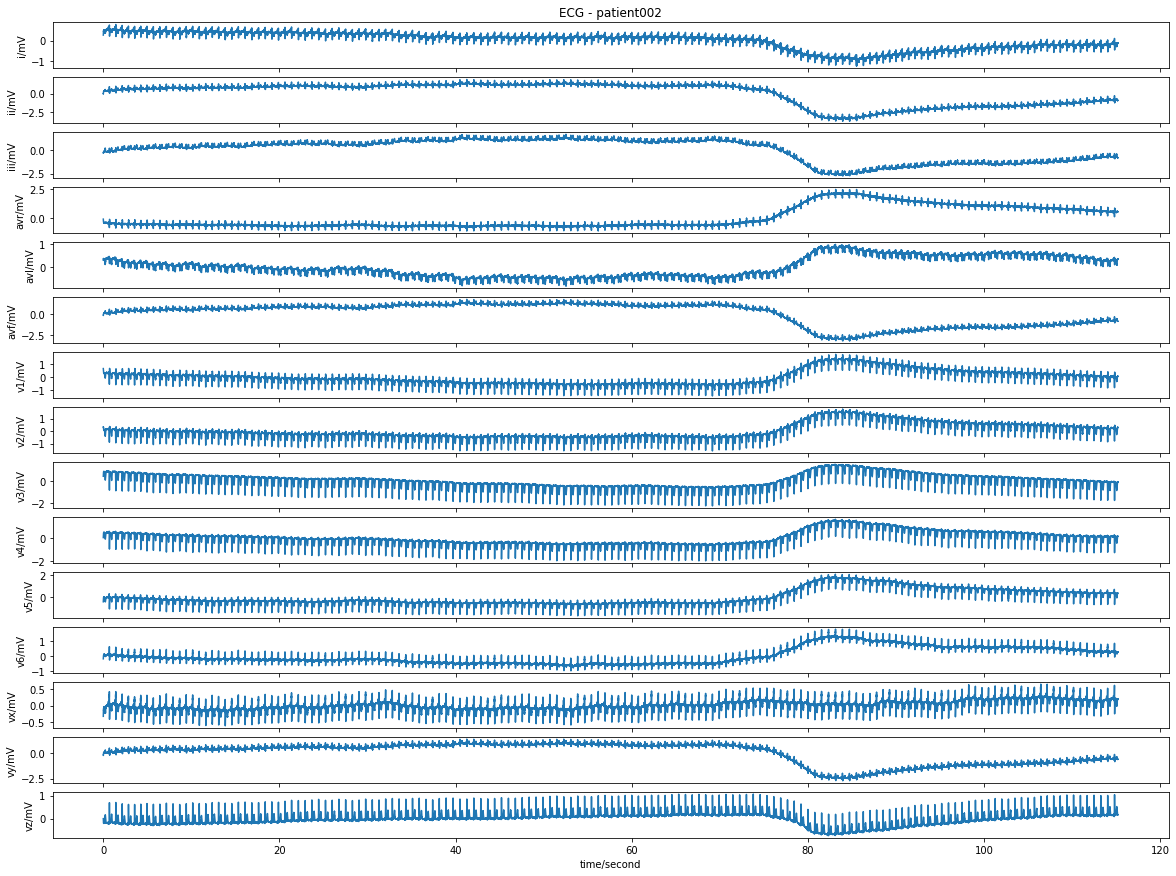

In [3]:
wfdb.plot_wfdb(record=record, title='ECG - ' + patient, figsize = (20, 15))

Each channel corresponds to a lead measured by a set of electrodes and provides a different picture of the heart. Each lead signal is stored in records.p_signal in a column vector (that is, physical signal, which is loaded by default by using the sampling frequency of the device). An experienced doctor understands the information given by each of the leads and is able to find heart anomalies or different diseases by studying them. 

For example, if we just want to read the i, ii, iii leads:


Text(0.5, 1.0, 'First 3 leads, patient002')

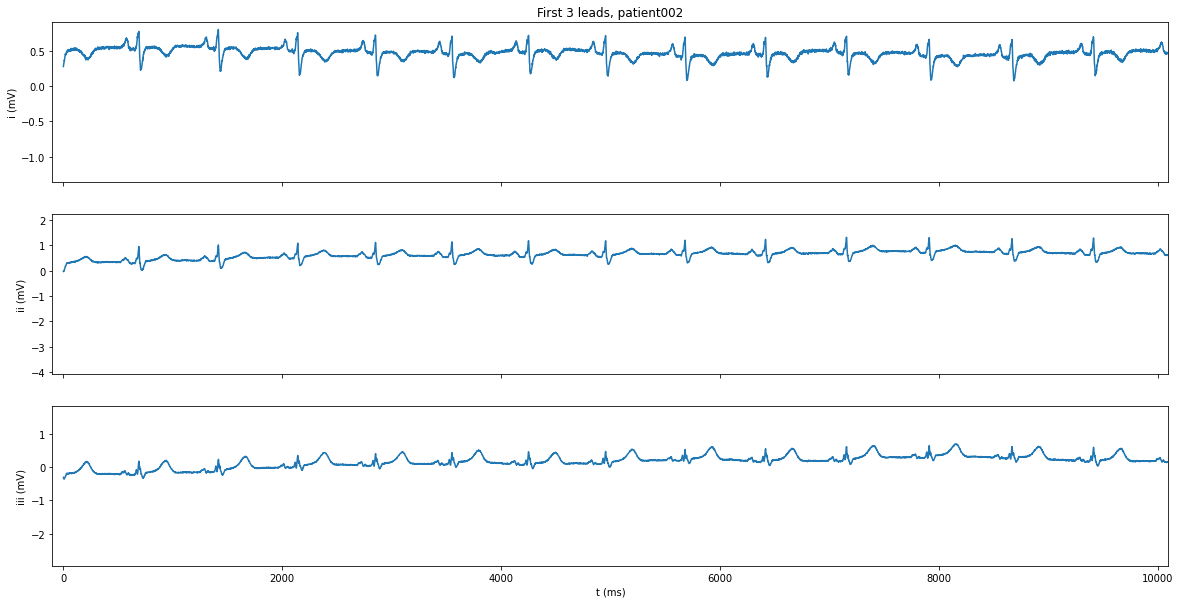

In [4]:
f, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
for ii in range(3):
    ax[ii].plot(record.p_signal[:, ii])
    ax[ii].set_ylabel(record.sig_name[ii]+" (mV)")
    ax[ii].set_xlim([-100, 10100])
    
ax[2].set_xlabel('t (ms)')
ax[0].set_title('First 3 leads, ' + patient)

For the rest of the exercise, I am going to focus on the second lead (ii) as it presents sharper Q and S peaks. 

## Data processing

While registering a ECG, several physiological non-cardiac signals may be present in our data. For example, the breathing of the patient leaves a baseline in the dataset that can be misunderstood when dealing with an ECG. Therefore, the first step I would take is to flatten the ECG by removing the baseline, which will be obtained by applying a LOWESS smoother (Cleveland W. S. 1981).

In [5]:
channel = 1
signal_0 = record.p_signal[:, channel]

x = np.arange(len(signal_0))
baseline = sm.nonparametric.lowess(signal_0, x, frac = 0.05)  # Frac parameter needs to be low as the outliers need to have a low weight in order not to loose too much information

signal_b = signal_0-baseline[:, 1]

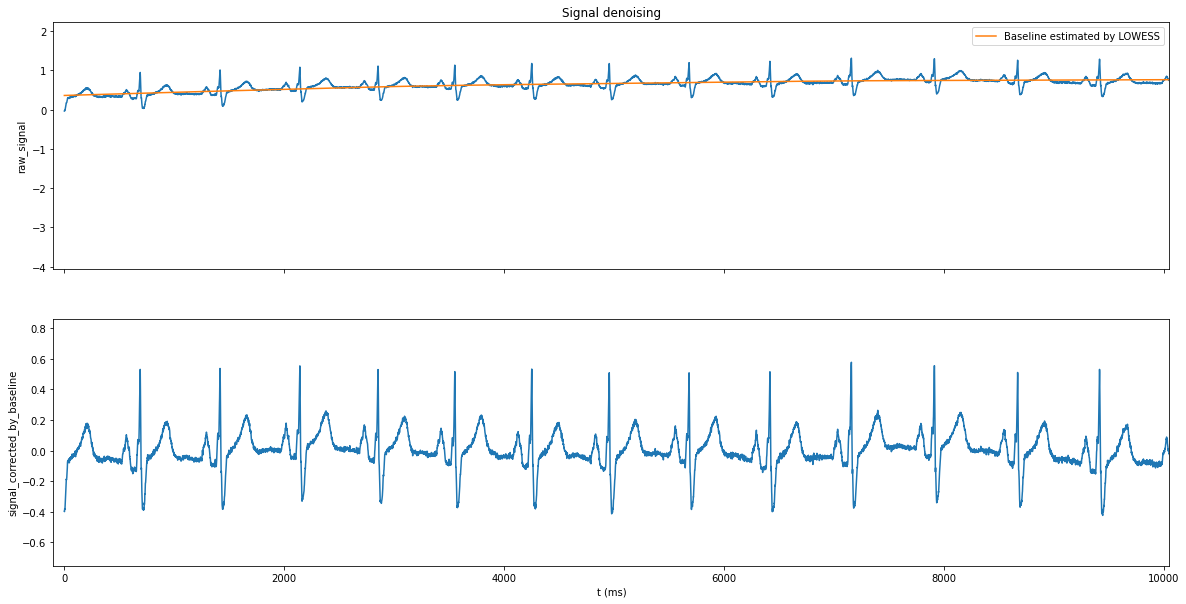

In [6]:
f, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(x, signal_0)
ax[0].plot(x, baseline[:, 1], label='Baseline estimated by LOWESS')
ax[1].plot(x, signal_b)
ax[0].set_ylabel('raw_signal')
ax[1].set_ylabel('signal_corrected_by_baseline')
ax[1].set_xlim([-100, 10050])
ax[1].set_xlabel('t (ms)')
ax[0].set_title('Signal denoising')
ax[0].legend()

## Identifying R and Q peaks

In order to measure the heart beats, I am going to identify the QRS complex in the signal. There are multiple QRS detection methods in literature (Eilers J., Chromik J. and Arnrich B. 2021: Choosing the Appropriate QRS Detector https://www.scitepress.org/Papers/2021/102346/102346.pdf), and the library wfdb provides two algorithms to detect it:

- GQRS: Trapezoid low-pass filtering + convolution with QRS filter. Learning phase then detection phase.
- XQRS: Band-pass filtering + moving wave integration + Ricker wavelet. Can conduct learning if desired.

I will perform and attempt with both methods:

In [7]:
# Use the GQRS algorithm to detect QRS locations in the first channel
gqrs_inds = processing.gqrs_detect(sig=signal_b, fs=record.fs)
xqrs_inds = processing.xqrs_detect(sig=signal_b, fs=record.fs)


Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


The XQRS attempt does not work properly with the current configuration. Further exploration would be needed to understand why. On the other side, the GQRS algorithm has worked succesfully:

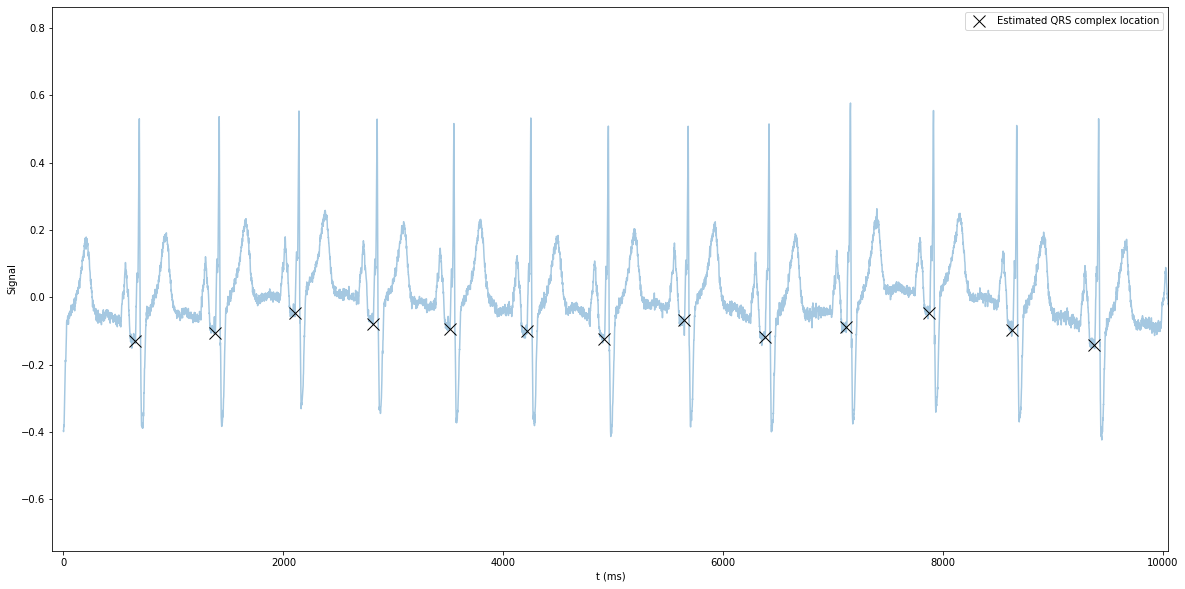

In [8]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(signal_b, color='C0', alpha=0.4)
ax.plot(gqrs_inds, signal_b[gqrs_inds], 'x', color='k',
        label='Estimated QRS complex location', markersize=12)
ax.set_xlim([-100, 10050])
ax.set_xlabel('t (ms)')
ax.set_ylabel('Signal')
plt.legend()

In order to match the location of the QRS with the local maxima (the R peaks), wfdb provides a function called correct_peaks. It takes as inputs the current location of the QRS complex, a search radius (the maximum horizontal shift allowed to find the local maxima) and a window size (the size of the moving average filter). As it gives also the option to search for local minima, we can also identify the S peaks. The search radius can be defined by using a heart reate in bpm. A maximum possible bpm would provide the search radius needed for any ECG. A value of 200 bpms would be used here (https://www.webmd.com/heart-disease/heart-failure/watching-rate-monitor):

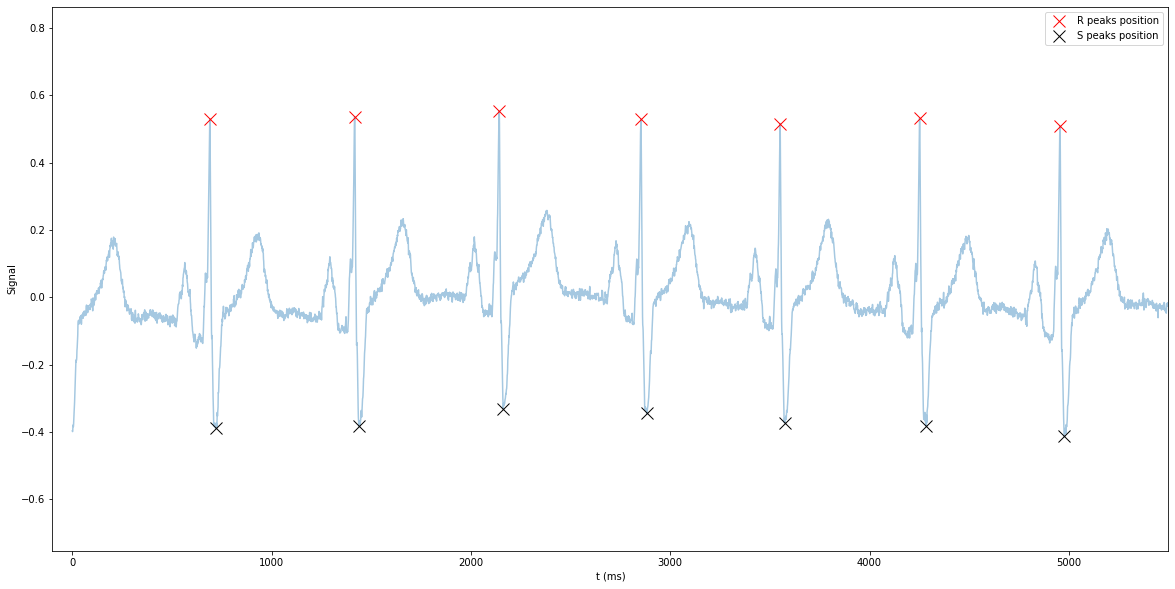

In [9]:
max_hr = 200
search_radius = int(record.fs * 60 / max_hr)


R_inds = processing.correct_peaks(signal_b, 
                                  peak_inds=gqrs_inds,
                                  search_radius=search_radius, 
                                  smooth_window_size=150)

S_inds = processing.correct_peaks(signal_b, 
                                  peak_inds=gqrs_inds,
                                  search_radius=search_radius,
                                  peak_dir='down',
                                  smooth_window_size=150)

f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(signal_b, color='C0', alpha=0.4)
ax.plot(R_inds, signal_b[R_inds], 'x', color='r',
        label='R peaks position', markersize=12)
ax.plot(S_inds, signal_b[S_inds], 'x', color='k',
        label='S peaks position', markersize=12)
ax.set_xlim([-100, 5500])
ax.set_xlabel('t (ms)')
ax.set_ylabel('Signal')
plt.legend()

With these peaks it is possible to measure the RS amplitude, the RR duration, and to compute the total number of beats as well as the mean heart rate from them, in beats per minute.

## Metrics: Heart rate, RR duration

In [10]:
RS_amplitude = signal_b[R_inds] - signal_b[S_inds]

total_beats = len(R_inds)

rr_duration = processing.calc_rr(qrs_locs=R_inds, fs=record.fs, rr_units='seconds')

hr = processing.compute_hr(sig_len=signal_b.shape[0], qrs_inds=R_inds, fs=record.fs)

mean_hr = processing.calc_mean_hr(rr_duration, fs = record.fs, rr_units='seconds')

print('Total beats in ' + str(int(len(signal_b)/1000)) + ' seconds: ' + str(total_beats))
print('Mean Heart Rate: ' + str(np.round(mean_hr,2)) + ' bps')

Total beats in 115 seconds: 152
Mean Heart Rate: 79.21 bps


We can also plot the heart rate and the RR progression curve:

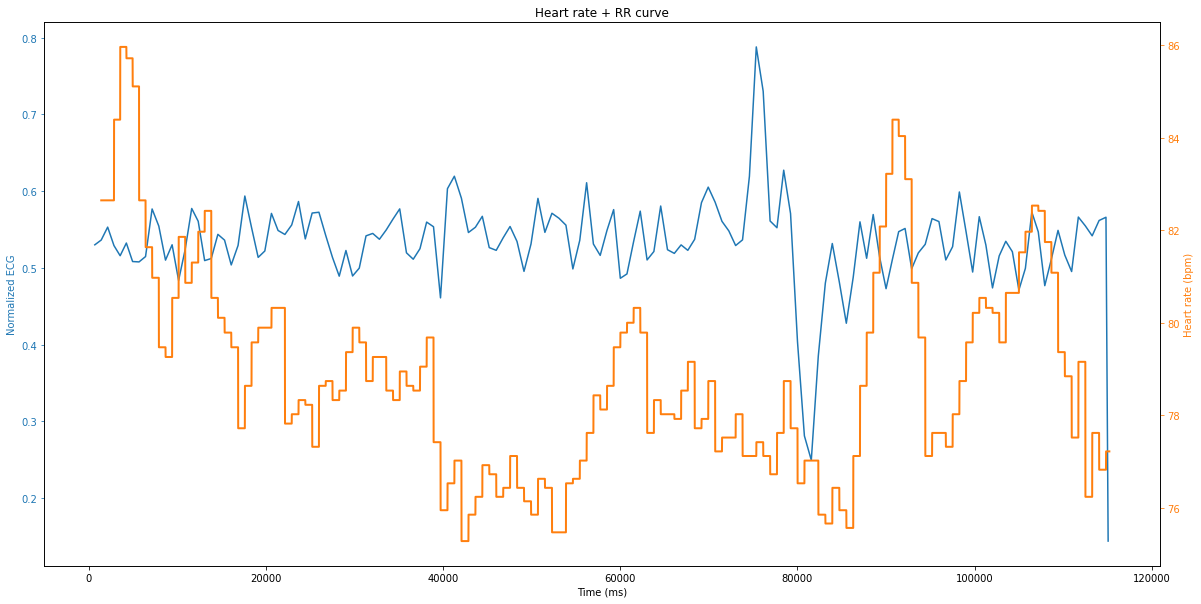

In [11]:
def plot_hr_rr(sig, hr, peak_inds, fs, title, figsize=(20, 10)):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate       
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(peak_inds, sig[peak_inds], color='C0', label='RR curve')
    ax_right.plot(np.arange(len(hr)), hr, label='Heart rate', color='C1', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('Normalized ECG', color='C0')
    ax_right.set_ylabel('Heart rate (bpm)', color='C1')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='C0')
    ax_right.tick_params('y', colors='C1')
    plt.show()
    
plot_hr_rr(signal_b, hr, R_inds, record.fs, 'Heart rate + RR curve')

The information provided in the header file is stored in record.comments. This information can be formatted into a dictionary structure, and it can be provided as an output with the measures taken in the ECG:

In [12]:
def parse_coms(record):
    head_info = {}
    for item in record.comments:
        elem = item.split(':')
        head_info[elem[0]] = elem[1].lstrip()
    
    keys =  list(head_info.keys())
    ii_diag = [i for i, x in enumerate(keys) if x == "Diagnose"][0]
    ii_hemo = [i for i, x in enumerate(keys) if x == "Hemodynamics"][0]
    ii_ther = [i for i, x in enumerate(keys) if x == "Therapy"][0]

    keys_diag = [x for i, x in enumerate(keys) if ii_diag < i < ii_hemo]
    keys_hemo = [x for i, x in enumerate(keys) if ii_hemo < i < ii_ther]
    keys_ther = [x for i, x in enumerate(keys) if ii_ther < i]
    
    header_all = {"age":head_info["age"], 
                  "sex":head_info["sex"], 
                  "ECG date":head_info["ECG date"], 
                  "Diagnose":{}, 
                  "Hemodynamics":{}, 
                  "Therapy":{}}

    for key in keys_diag:
        header_all['Diagnose'][key] = head_info[key]
    for key in keys_hemo:
        header_all['Hemodynamics'][key] = head_info[key]
    for key in keys_ther:
        header_all['Therapy'][key] = head_info[key]
        
    return header_all

patient_info = parse_coms(record)

In [13]:
patient_info['ECG'] = {'Heart rate': np.round(mean_hr, 3), 
                       'Total beats (' + str(int(len(signal_b)/1000)) + ' seconds)': total_beats, 
                       'Average RS amplitude': np.round(np.average(RS_amplitude),3)}
patient_info['ECG']

{'Heart rate': 79.214,
 'Total beats (115 seconds)': 152,
 'Average RS amplitude': 0.913}

Annotations can be created from the results obtained. In this case, I will label as normal beat every R peak location:

In [14]:
ann1 = wfdb.Annotation(record_name='rec1', extension='atr',
                       sample=R_inds, symbol = ['N' for ii in range(len(R_inds))],
                       chan = channel*np.ones(len(R_inds)), fs = record.fs)

wfdb.wrann(record_name=ecg, extension='atr',
           sample = R_inds, symbol = ['N' for ii in range(len(R_inds))],
           chan = channel*np.ones(len(R_inds)),
           fs = record.fs)

The last piece of code returns an annotation file which can be used to label ECGs and in future Deep Learning approaches (to classify ECGs depending on the anomaly we are searching for).

## Other ideas to be developed

The signal can be also denoised to facilitate the automatic peak detection on the signal. In this case I am going to use a rolling average (Xiang Y., Lin Z., Meng J. 2018.) over 5 samples

Text(0.5, 1.0, 'Signal denoising')

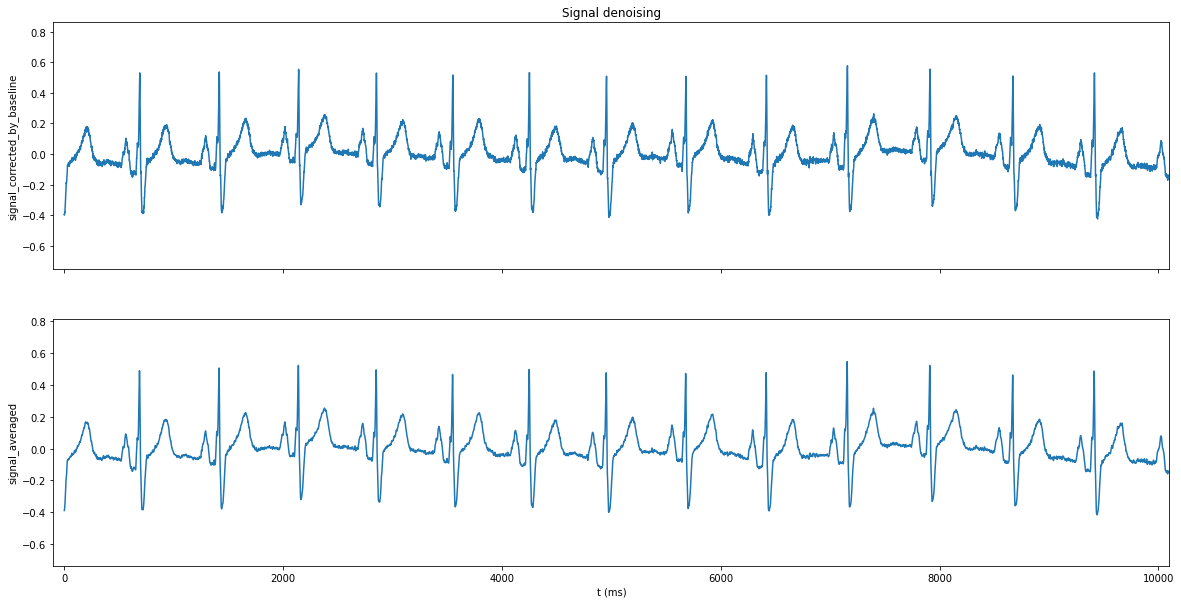

In [15]:
## Rolling average over N samples
def signal_den_a(sig, N):
    sa = np.zeros(len(sig)) 
    for ii in range(len(sig)-N):
        sa[ii]= np.sum(sig[ii:ii+N])/N
    return sa


signal_a = signal_den_a(signal_b, 5)

f, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(x, signal_b)
ax[1].plot(x, signal_a)
ax[0].set_ylabel('signal_corrected_by_baseline')
ax[1].set_ylabel('signal_averaged')
ax[1].set_xlim([-100, 10100])
ax[1].set_xlabel('t (ms)')
ax[0].set_title('Signal denoising')

At the end, the result was not convincing (introduction of artifacts in some pulses) so I did not use it as the QRS complex was clearly defined already. For a deeper analysis of the rest of components and to increase sensitivity, a denoising algorithm can be developed and applied to an ECG.

### Convolutional neural network

The works of Xiang Y., Lin Z., Meng J. (2018) and Sarlija, M., Jurisic F., Popovic S. (2017) propose a QRS detection method based on a two-level CNN. This process would require a normalization of the signals:

In [16]:
n_signal = processing.normalize_bound(signal_b, lb=0, ub=1)

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

## CNN structure implemented in Sarlija, M., Jurisic F., Popovic S. (2017)

input_shape = (145, 1) 

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(32, 5, strides = 1, activation='relu'),
    layers.Dropout(0.5),
    layers.MaxPool1D(pool_size=3, strides=2, padding='valid'),
    layers.Conv1D(32, 5, strides=1, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Softmax()
])
model.summary()

## We'd need to split our dataset in train/test and then select the right input shape.

2022-09-06 21:37:14.275797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 21:37:14.275813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 141, 32)           192       
                                                                 
 dropout (Dropout)           (None, 141, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 70, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 32)            5152      
                                                                 
 dropout_1 (Dropout)         (None, 66, 32)            0         
                                                                 
 dense (Dense)               (None, 66, 32)            1056      
                                                        

2022-09-06 21:37:15.375587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 21:37:15.375893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 21:37:15.375936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-06 21:37:15.375974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-06 21:37:15.376011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

To be able to use this CNN, we'd need first to divide the entire dataset in train/test sets. The same dataset provides a set of them called CONTROL which could be used to test. This would be my next step making sure that a CNN like this one would provide meaningful insights, but it would require to annotate and select the right data to train and to test. This could be done by validating the datasets through the work presented in this notebook (by detecting the R, S peaks + perhaps a filter to determine the PR segment and the position of the Q peak).

## Bibliography

### Data resources:

- Bousseljot R, Kreiseler D, Schnabel, A. Nutzung der EKG-Signaldatenbank CARDIODAT der PTB über das Internet. Biomedizinische Technik, Band 40, Ergänzungsband 1 (1995) S 317

- Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

### Python libraries:

- Xie, C., McCullum, L., Johnson, A., Pollard, T., Gow, B., & Moody, B. (2022). Waveform Database Software Package (WFDB) for Python (version 4.0.0). PhysioNet. https://doi.org/10.13026/mmpm-2v55.

- Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo, Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis, Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow, Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia, Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster, Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens, Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker, Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas, Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke, Yuan Yu, and Xiaoqiang Zheng. TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. Software available from tensorflow.org.

- Seabold, Skipper, and Josef Perktold. “Statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.

### Methods

- J Eilers, J Chromik, B Arnrich 2021, Choosing the Appropriate QRS Detector. BIOSIGNALS, 50-59

- Xiang, Y., Lin, Z. & Meng, J. Automatic QRS complex detection using two-level convolutional neural network. BioMed Eng OnLine 17, 13 (2018). https://doi.org/10.1186/s12938-018-0441-4

- M. Šarlija, F. Jurišić and S. Popović, "A convolutional neural network based approach to QRS detection," Proceedings of the 10th International Symposium on Image and Signal Processing and Analysis, 2017, pp. 121-125, doi: 10.1109/ISPA.2017.8073581.

- Cleveland, W.S. (1981) LOWESS: A program for smoothing scatter plots by robust locally weighted regression. The American Statistician, 35, 54. http://dx.doi.org/10.2307/2683591

### Other references

- ECG theory and instrumentation:

    - http://www.emtresource.com/category/resources/ecg/
    - https://www.cablesandsensors.eu/pages/12-lead-ecg-placement-guide-with-illustrations
    - https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/
    - https://www.ncbi.nlm.nih.gov/books/NBK551635/
    
- Demo on wfdb python:

    - https://github.com/MIT-LCP/wfdb-python/blob/main/demo.ipynb

